# 使用Pytorch对图像进行语义分割
语义分割是将图像中的**每一个像素**分类到某个类别中的图像处理过程。

In [20]:
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt 
import torch
import numpy as np

In [10]:
# Load model (FCN with a Resnet101 backbone)
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
print(fcn)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

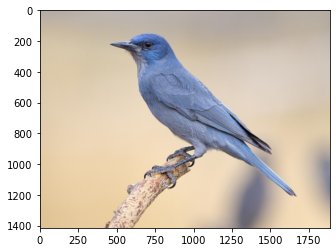

In [6]:
img = Image.open('./raw/semantic_segmentation/pinyon-jay-bird.jpg')
plt.imshow(img)

In [9]:
img_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])
inp = img_transform(img).unsqueeze(0)
print(inp.shape)

torch.Size([1, 3, 224, 224])


In [17]:
# Forward pass
with torch.no_grad():
    out = fcn(inp)

In [23]:
om = torch.argmax(out['out'],dim=1).detach().numpy()
om = om.squeeze()
print(om.shape)
print(np.unique(om))

(224, 224)
[0 3]


In [28]:
# Decode fcn output
idx2name = {
    0: 'background', 
    1: 'aeroplane',
    2: 'bicycle', 
    3: 'bird', 
    4: 'boat', 
    5: 'bottle',
    6: 'bus' ,  
    7: 'car',  
    8: 'cat', 
    9: 'chair', 
    10: 'cow',
    11: 'dining table', 
    12: 'dog', 
    13: 'horse', 
    14: 'motorbike', 
    15: 'person',
    16: 'potted plant', 
    17: 'sheep', 
    18: 'sofa', 
    19: 'train', 
    20: 'tv/monitor'
}
def decode_segmap(img, num_category=21):
    label_colors = np.array([(0, 0, 0),        # 00: background
                            (128, 0, 0),      # 01: aeroplane 
                            (0, 128, 0),      # 02: bicycle
                            (128, 128, 0),    # 03: bird
                            (0, 0, 128),      # 04: boat
                            (128, 0, 128),    # 05: bottle
                            (0, 128, 128),    # 06: bus
                            (128, 128, 128),  # 07: car
                            (64, 0, 0),       # 08: cat
                            (192, 0, 0),      # 09: chair 
                            (64, 128, 0),     # 10: cow
                            (192, 128, 0),    # 11: dining table
                            (64, 0, 128),     # 12: dog
                            (192, 0, 128),    # 13: horse
                            (64, 128, 128),   # 14: motorbike
                            (192, 128, 128),  # 15: person
                            (0, 64, 0),       # 16: potted plant
                            (128, 64, 0),     # 17: sheep
                            (0, 192, 0),      # 18: sofa
                            (128, 192, 0),    # 19: train
                            (0, 64, 128)      # 20: tv/monitor
                            ])
    r = np.zeros_like(img).astype(np.uint8)
    g = np.zeros_like(img).astype(np.uint8)
    b = np.zeros_like(img).astype(np.uint8)
    for cate in range(num_category):
        idx = (img == cate)
        r[idx] = label_colors[cate, 0]
        g[idx] = label_colors[cate, 1]
        b[idx] = label_colors[cate, 2]
    result = np.stack([r, g, b], axis=2)
    return result   

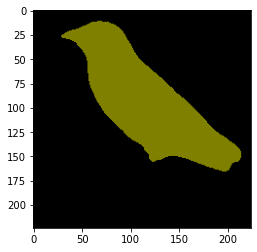

In [29]:
res = decode_segmap(om)
plt.imshow(res)

## 以下使用DeepLab来进行语义分割

In [34]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
with torch.no_grad():
    out = dlab(inp)['out'].numpy().squeeze()

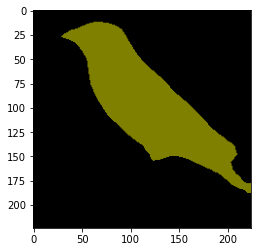

In [37]:
om = np.argmax(out, axis=0)
res = decode_segmap(om)
plt.imshow(res)

In [41]:
def segment(model, path):
    img = Image.open(path)
    plt.imshow(img); plt.axis('off'); plt.show()
    trf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    inp = trf(img).unsqueeze(0)
    out = model(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().numpy()
    res = decode_segmap(om)
    plt.imshow(res); plt.axis('off')

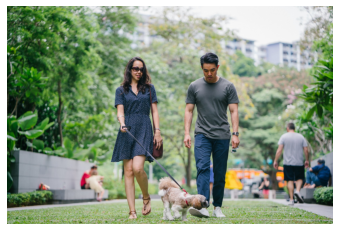

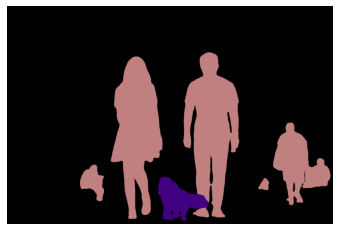

In [42]:
path = './raw/semantic_segmentation/person.jpeg'
segment(dlab, path)

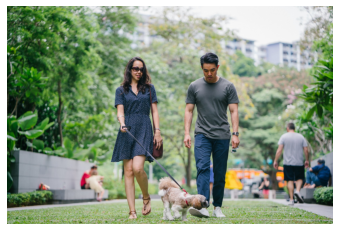

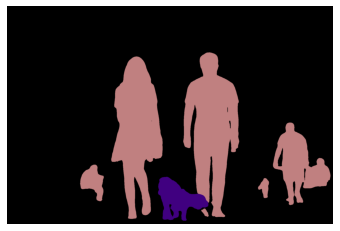

In [43]:
segment(fcn, path)